In [1]:
import re
import nltk

import requests
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression, LogisticRegressionCV
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

from time import sleep

### Modeling

In [3]:
df = pd.read_csv('./datasets/combined_data.csv')
df = df.drop(columns = 'Unnamed: 0')
df['label'] = df['label'].map({'true' : 0,'false' : 1,'misleading' : 1})

In [4]:
#Karl
vec = CountVectorizer()
X = df['text']
y = df['label']
cvX = vec.fit_transform(X)
tsvd = TruncatedSVD(n_components = 100, random_state = 42)

In [5]:
tsvd.fit_transform(cvX)
tsvd.get_params()

{'algorithm': 'randomized',
 'n_components': 100,
 'n_iter': 5,
 'random_state': 42,
 'tol': 0.0}

In [6]:
#Alexis
X = df['text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

In [7]:
pipe_bag = Pipeline([
    ('cvec', CountVectorizer()),
    ('bag', BaggingClassifier() )
])

bag_params = {
    'cvec__ngram_range': [(1,1),(1, 2)],
    'cvec__stop_words': [None, 'english']
}

gs_bag = GridSearchCV(pipe_bag, bag_params, cv =5)

In [8]:
gs_bag.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('bag', BaggingClassifier())]),
             param_grid={'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [None, 'english']})

In [9]:
gs_bag.score(X_test, y_test)

0.8694992412746586

In [10]:
gs_bag.score(X_train, y_train)

0.9889984825493171

In [17]:
# pegah 

ps = PorterStemmer()
corpus = []
for i in range(0, len(df)):
    review = re.sub('[^a-zA-Z]', ' ', df['text'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)
    
cv = CountVectorizer(max_features=5000,ngram_range=(1,3))
X = cv.fit_transform(corpus).toarray()
y =  df['label'].map(lambda x: 1 if x== 'true' else 0 )

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42)

mnb=MultinomialNB(alpha=0.1)
mnb.fit(X_train,y_train)
y_pred= mnb.predict(X_test)
score = metrics.accuracy_score(y_test, y_pred)

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


accuracy:   1.000
Confusion matrix, without normalization


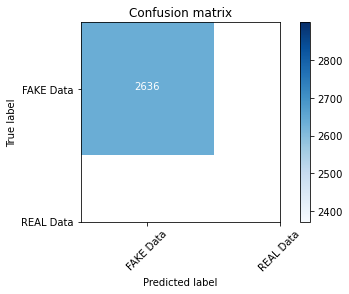

In [19]:
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['FAKE Data', 'REAL Data'])
plt.savefig('./imgs/tfidflogreg-cm1.png')